In [1]:
import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import cmasher as cmr
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as ac
import astropy.units as au
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# import string

In [2]:
plt.style.use('ncr-paper.mplstyle')

In [3]:
# "qdset" is a xarray.Dataset storing the (16, 50, 84) percentile values and mean and std for each model's time series into an effectively 3D array.
with xr.open_dataarray("../data/percentiles_all.nc") as qdset:
    # get median values and convert it into pandas.DataFrame
    mid_df = qdset.sel(q="50").to_dataset(dim="variable").drop("q").to_dataframe()
    mid_logdf = np.log10(mid_df)

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


In [4]:
W = qdset.sel(variable="W",q="mean")

In [5]:
datadir = "../data/lowZ-filling-data"

In [20]:
m

'LGR4_4pc_NCR.full.b1.v3.iCR4.Zg3.Zd3.xy1024.eps1.e-8'

In [25]:
def get_Zdust_from_name(m):
    return float(m[m.rfind("Zd"):m.rfind("xy")][2:-1])
def get_Zgas_from_name(m):
    return float(m[m.rfind("Zg"):m.rfind("Zd")][2:-1])
def get_beta_from_name(m):
    return float(m[m.rfind(".b"):m.rfind(".v")][2:])

def get_color(value,cmin = 2.7, cmax = 6.3, cmap=cmr.guppy):
    norm = Normalize(vmin=cmin, vmax=cmax)
    color = cmap(norm(np.log10(value)))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    return color,sm
def get_symbol(name):
    if "Zd0.025" in name:
        marker="s"
    elif "Om01" in name:
        marker="v"
    elif "Om02" in name:
        marker="^"
    elif "b10" in name and "S05" not in name:
        marker="d"
    else:
        marker="o"
    return marker

In [7]:
dsetall = dict()
for m in qdset["name"].data:
    with xr.open_dataset(os.path.join(datadir,f"{m}.filling.nc")) as dset:
        dsetall[m] = dset

In [8]:
m

'LGR4_4pc_NCR.full.b1.v3.iCR4.Zg3.Zd3.xy1024.eps1.e-8'

In [22]:
def get_model_name(basename, beta=True, zonly=False):
    Z_gas = get_Zgas_from_name(basename)
    Z_dust = get_Zdust_from_name(basename)

    if "S30" in basename:
        head = "S30"
    elif "S150" in basename:
        head = "S150"
        if "Om01" in basename:
            head += "-Om100q0"
        elif "Om02" in basename:
            head += "-Om200"
    elif "S100" in basename:
        head = "S100"
    elif "S05" in basename:
        head = "S05"
    else:
        head = basename.split("_")[0]
        if beta:
            b = get_beta_from_name(m)
            head += f"-b{int(b)}"
    if Z_gas == Z_dust:
        ztail = f"Z{Z_gas:3.1f}"
    else:
        ztail = f"Zg{Z_gas:3.1f}Zd{Z_dust:5.3f}"
    if zonly:
        return ztail
    else:
        if "rstZ01" in basename:
            ztail += "r"
        return "{}-{}".format(head, ztail)

In [57]:
with open("fcnm.csv","w") as fp:
    fp.write(f"model,Zgas,Zdust,Sgas_16,Sgas_50,Sgas_84,fcnm_16,fcnm_50,fcnm_84\n")
    for m in sorted(dsetall):
        fp.write(get_model_name(m))
        zp_ph = dsetall[m]
        zmax = zp_ph["z"].max()
        Sgas_16,Sgas_50,Sgas_84 = Sgas.sel(name=m,q=["16","50","84"]).data
        fcnm_16,fcnm_50,fcnm_84 = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest').sel(q=[0.16,0.50,0.84]).data
        Zgas = get_Zgas_from_name(m)
        Zdust = get_Zdust_from_name(m)
        for v in [Zgas, Zdust, Sgas_16, Sgas_50, Sgas_84, fcnm_16, fcnm_50, fcnm_84]:
            fp.write(f",{v:.3f}")
        fp.write("\n")

In [60]:
import pandas as pd
df = pd.read_csv("fcnm.csv")

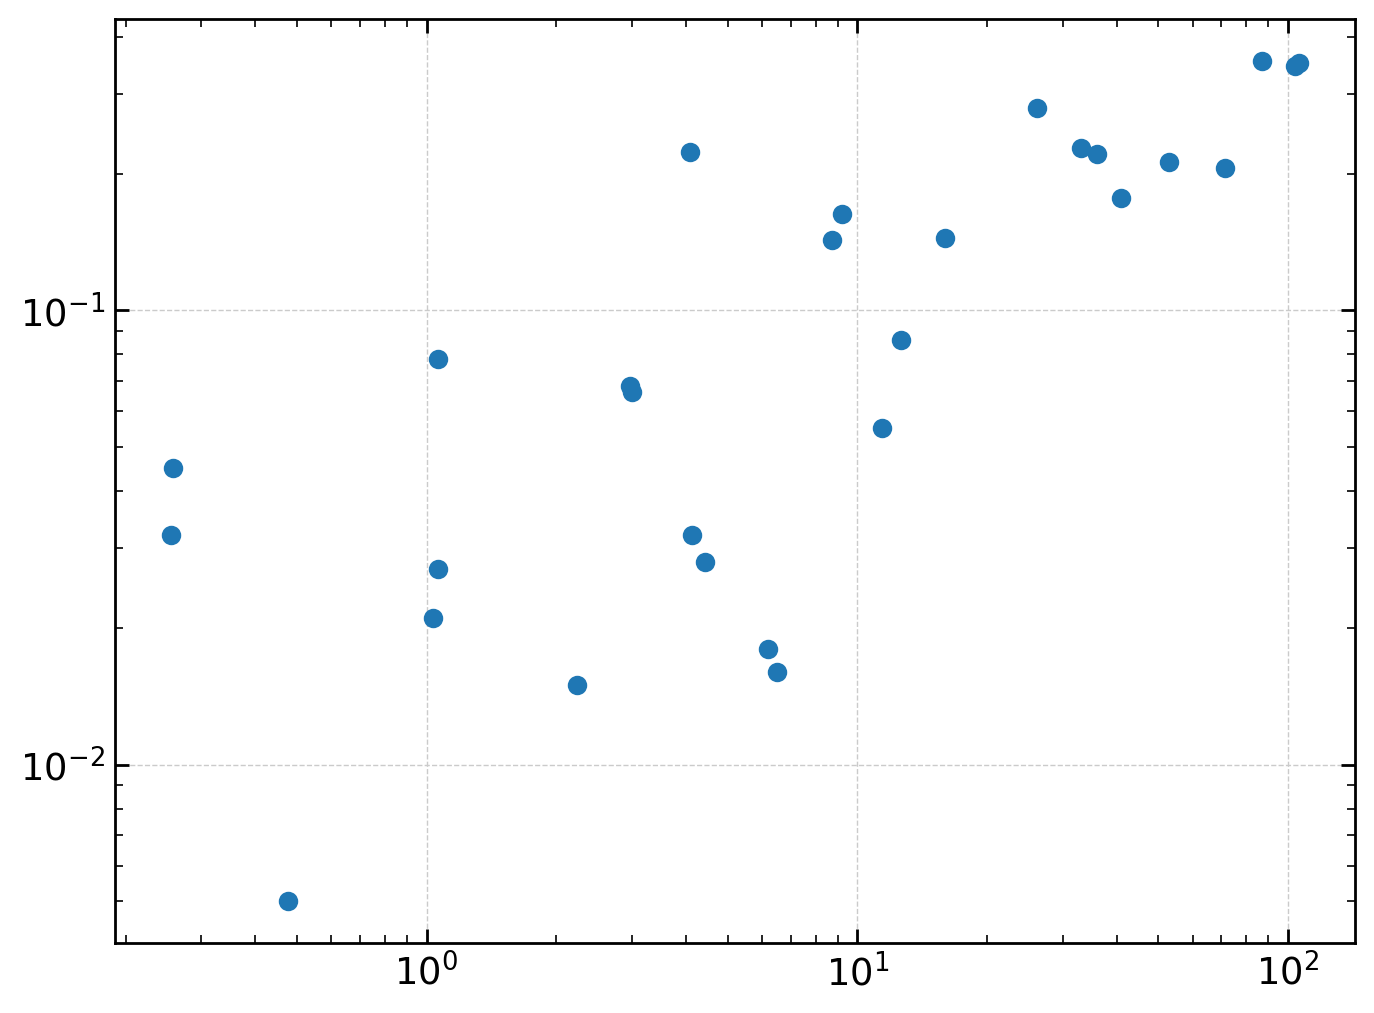

In [65]:
plt.plot(df["Zdust"]*df["Sgas_50"],df["fcnm_50"],'o')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, '$f_{\\rm CNM}$')

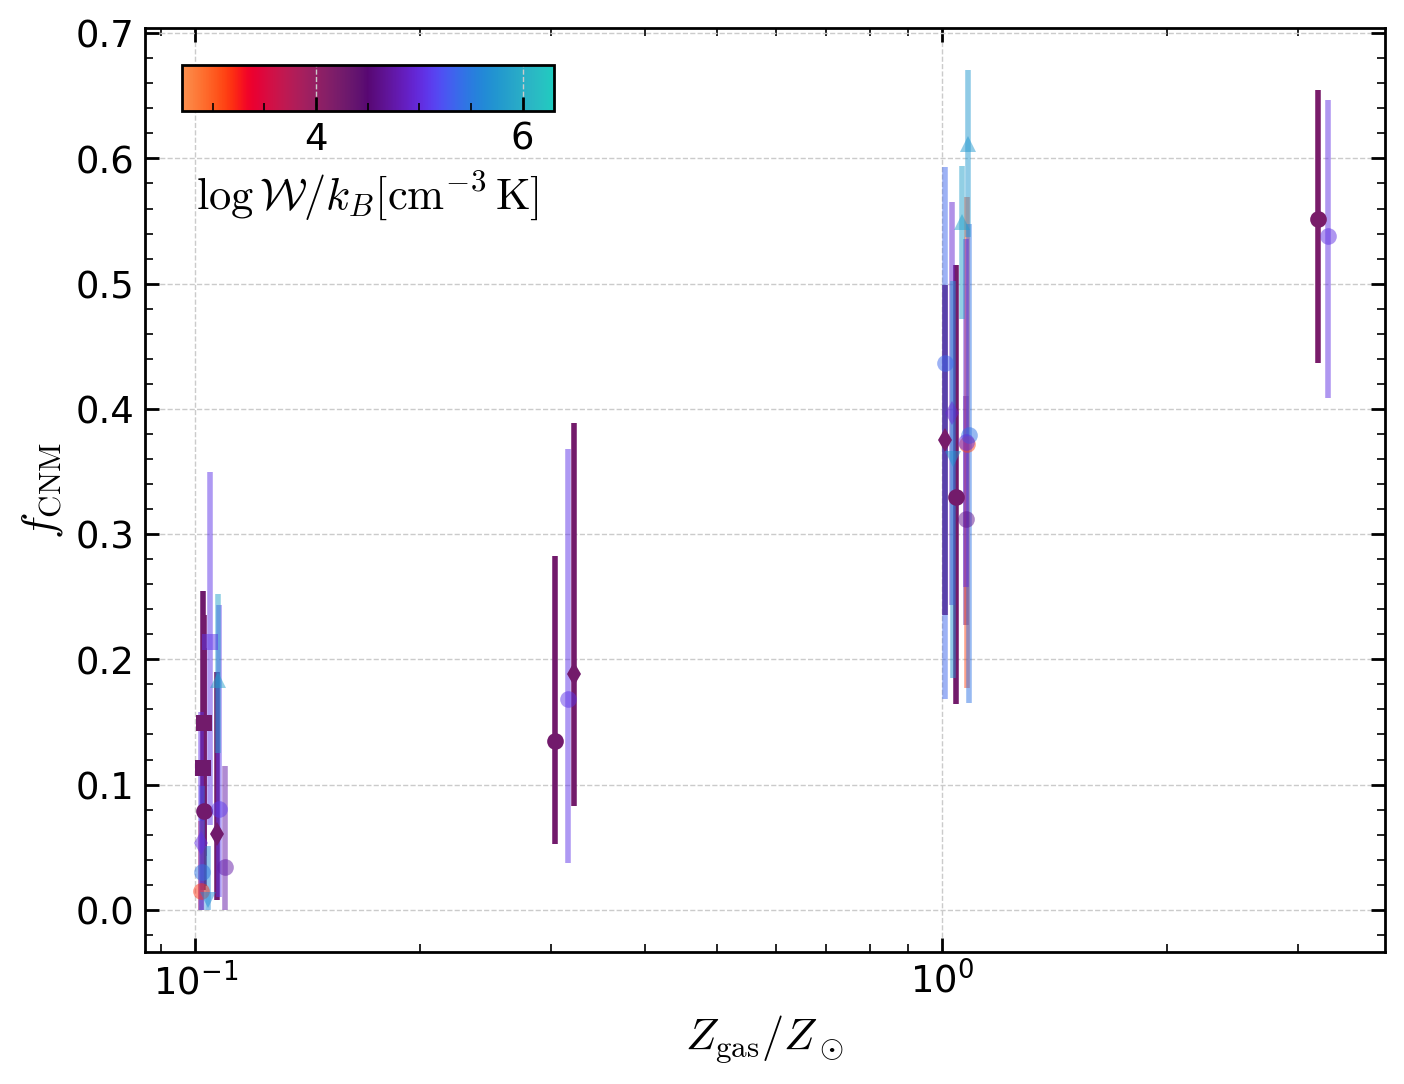

In [8]:
for m in dsetall:
    if not m.startswith("R8_8pc_NCR."):
        alpha=0.5
    else:
        alpha=1.0
    zp_ph = dsetall[m]
    kwargs = dict(marker=get_symbol(m))
    color, sm =get_color(W.sel(name=m))
    kwargs.update(dict(color=color))
    Z = get_Zgas_from_name(m)
    zmax = zp_ph["z"].max()
    zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    plt.errorbar(Z*(1+0.1*np.random.rand()),qmid,[[qmid-ql],[qu-qmid]],
                 mew=0,alpha=alpha,**kwargs)

    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

ax = plt.gca()
axins = inset_axes(ax, loc=2, borderpad=1, width="30%", height="5%")
cbar = plt.colorbar(
    sm, cax=axins, orientation="horizontal", label=r"$\log {\cal W}/k_B [{\rm cm^{-3}\,K}]$"
)

plt.sca(ax)
plt.xscale('log')
plt.xlabel(r"$Z_{\rm gas}/Z_\odot$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1.1,0)

# plt.yscale('log')



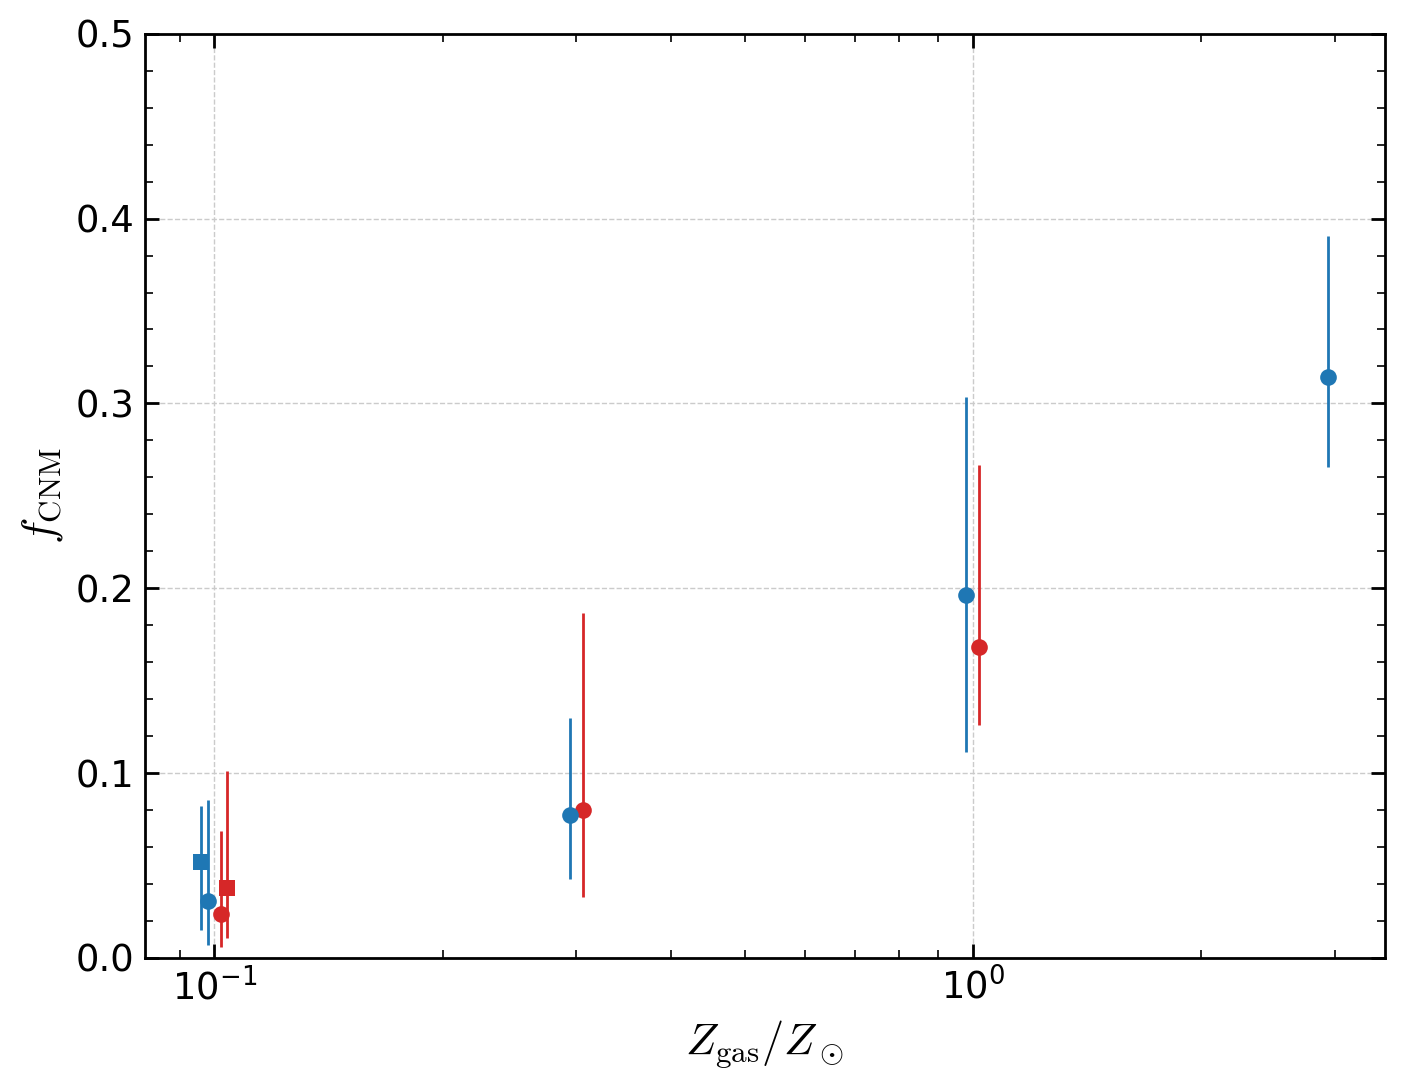

In [11]:
for m in dsetall:
    if not m.startswith("R8_8pc_NCR."):
        continue
    zp_ph = dsetall[m]
    # kwargs = dict(marker=get_symbol(m))
    if 'b10' in m:
        color="C3"
        offset=0.02
    else:
        color="C0"
        offset=-0.02
    Z = get_Zdust_from_name(m)
    marker="o"
    if Z == 0.025:
        offset = offset*2
        marker = "s"
    kwargs = dict(marker=marker,color=color,lw=1)
    # color, sm =get_color(W.sel(name=m))
    # color, sm =get_color(W.sel(name=m))
    # kwargs.update(dict(color=color))

    Z = get_Zgas_from_name(m)
    zmax = zp_ph["z"].max()
    # zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    plt.errorbar(Z*(1+offset),qmid,[[qmid-ql],[qu-qmid]],
                 mew=0,alpha=1,**kwargs)

    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

# ax = plt.gca()
# axins = inset_axes(ax, loc=2, borderpad=1, width="30%", height="5%")
# cbar = plt.colorbar(
#     sm, cax=axins, orientation="horizontal", label=r"$\log {\cal W}/k_B [{\rm cm^{-3}\,K}]$"
# )
# plt.sca(ax)

plt.xscale('log')
plt.xlabel(r"$Z_{\rm gas}/Z_\odot$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1.1,0)
plt.ylim(0,0.5)

# plt.yscale('log')

plt.savefig("../figures/Z-phase-R8.png")

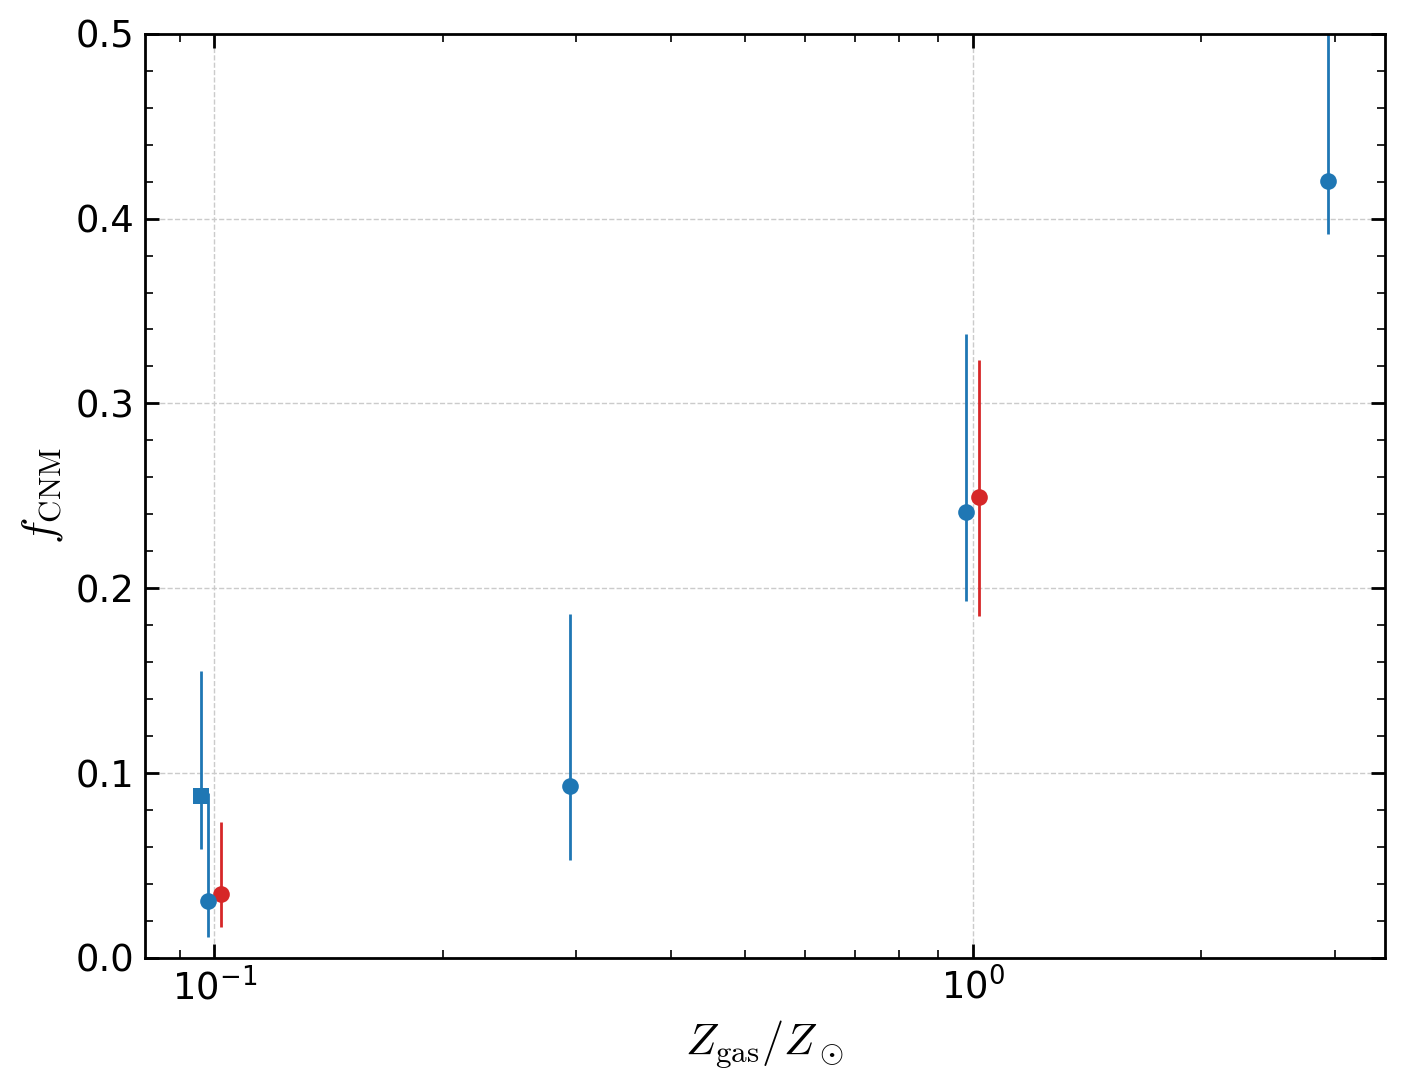

In [12]:
for m in dsetall:
    if not m.startswith("LGR4_4pc_NCR."):
        continue
    zp_ph = dsetall[m]
    # kwargs = dict(marker=get_symbol(m))
    if 'b10' in m:
        color="C3"
        offset=0.02
    else:
        color="C0"
        offset=-0.02
    Z = get_Zdust_from_name(m)
    marker="o"
    if Z == 0.025:
        offset = offset*2
        marker = "s"
    kwargs = dict(marker=marker,color=color,lw=1)
    # color, sm =get_color(W.sel(name=m))
    # color, sm =get_color(W.sel(name=m))
    # kwargs.update(dict(color=color))

    Z = get_Zgas_from_name(m)
    zmax = zp_ph["z"].max()
    # zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    plt.errorbar(Z*(1+offset),qmid,[[qmid-ql],[qu-qmid]],
                 mew=0,alpha=1,**kwargs)

    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

# ax = plt.gca()
# axins = inset_axes(ax, loc=2, borderpad=1, width="30%", height="5%")
# cbar = plt.colorbar(
#     sm, cax=axins, orientation="horizontal", label=r"$\log {\cal W}/k_B [{\rm cm^{-3}\,K}]$"
# )
# plt.sca(ax)

plt.xscale('log')
plt.xlabel(r"$Z_{\rm gas}/Z_\odot$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1.1,0)
plt.ylim(0,0.5)

# plt.yscale('log')

plt.savefig("../figures/Z-phase-LGR4.png")

R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8


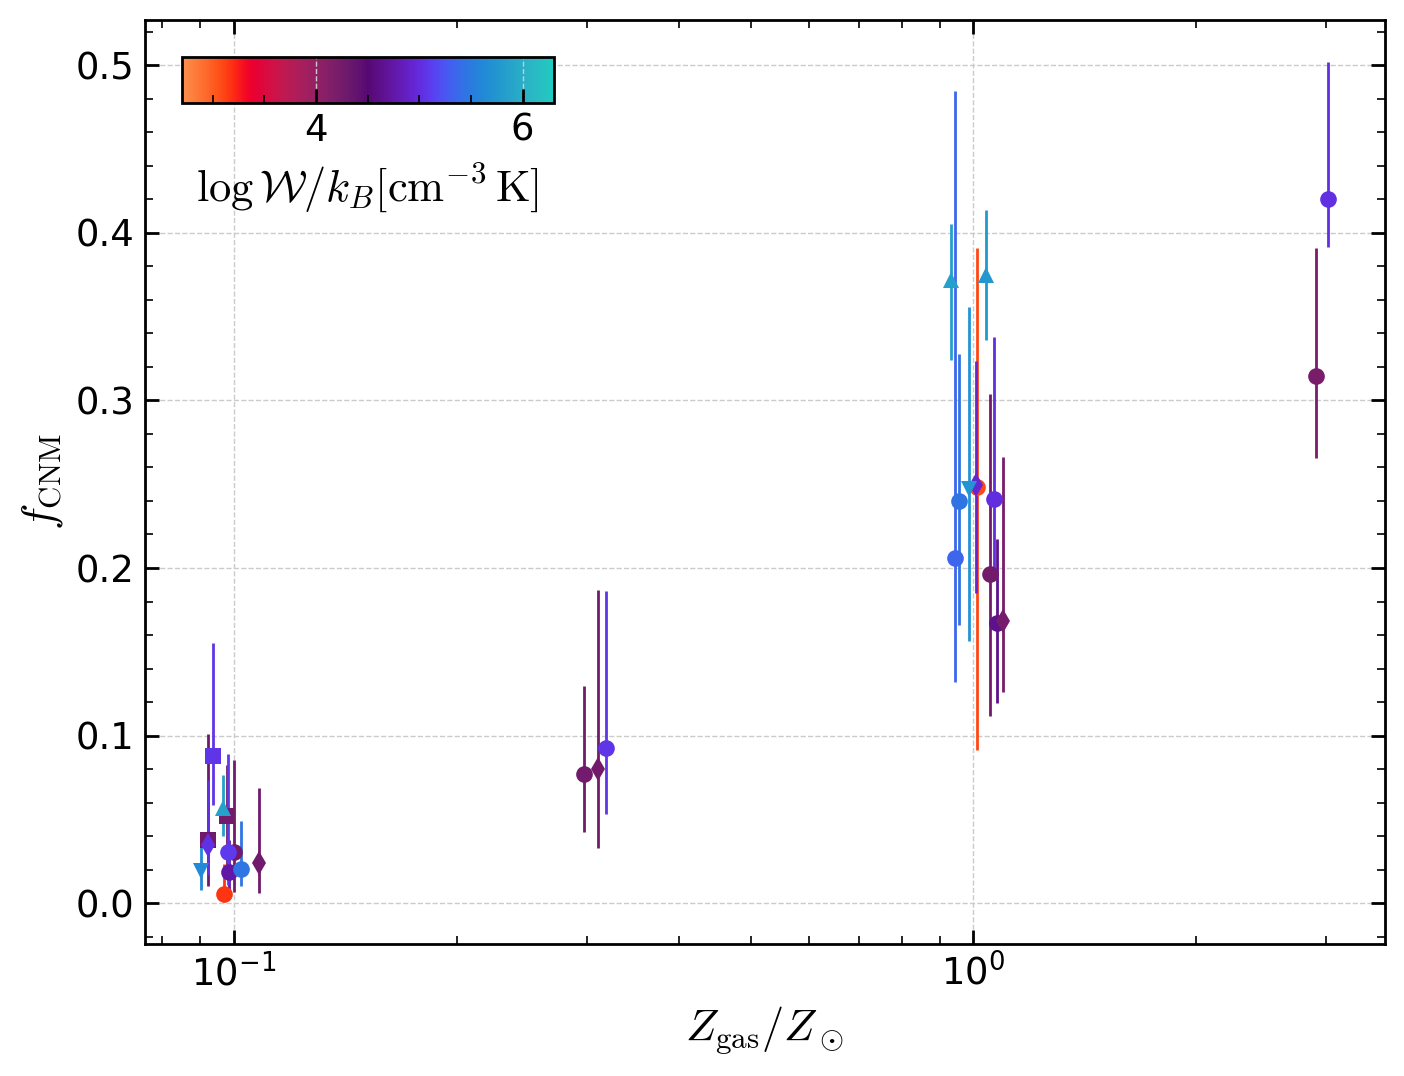

In [70]:
for m in dsetall:
    print(m)
    zp_ph = dsetall[m]
    kwargs = dict(marker=get_symbol(m))
    color, sm =get_color(W.sel(name=m))
    kwargs.update(dict(color=color))
    Z = get_Zgas_from_name(m)
    zmax = zp_ph["z"].max()
    # zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    plt.errorbar(Z*(0.9+0.2*np.random.rand()),qmid,[[qmid-ql],[qu-qmid]],
                 lw=1,mew=0,alpha=1,**kwargs)

    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

ax = plt.gca()
axins = inset_axes(ax, loc=2, borderpad=1, width="30%", height="5%")
cbar = plt.colorbar(
    sm, cax=axins, orientation="horizontal", label=r"$\log {\cal W}/k_B [{\rm cm^{-3}\,K}]$"
)

plt.sca(ax)
plt.xscale('log')
plt.xlabel(r"$Z_{\rm gas}/Z_\odot$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1.1,0)

# plt.yscale('log')
plt.savefig("../figures/Z-phase-all.png")


R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8


Text(0, 0.5, '$f_{\\rm CNM}$')

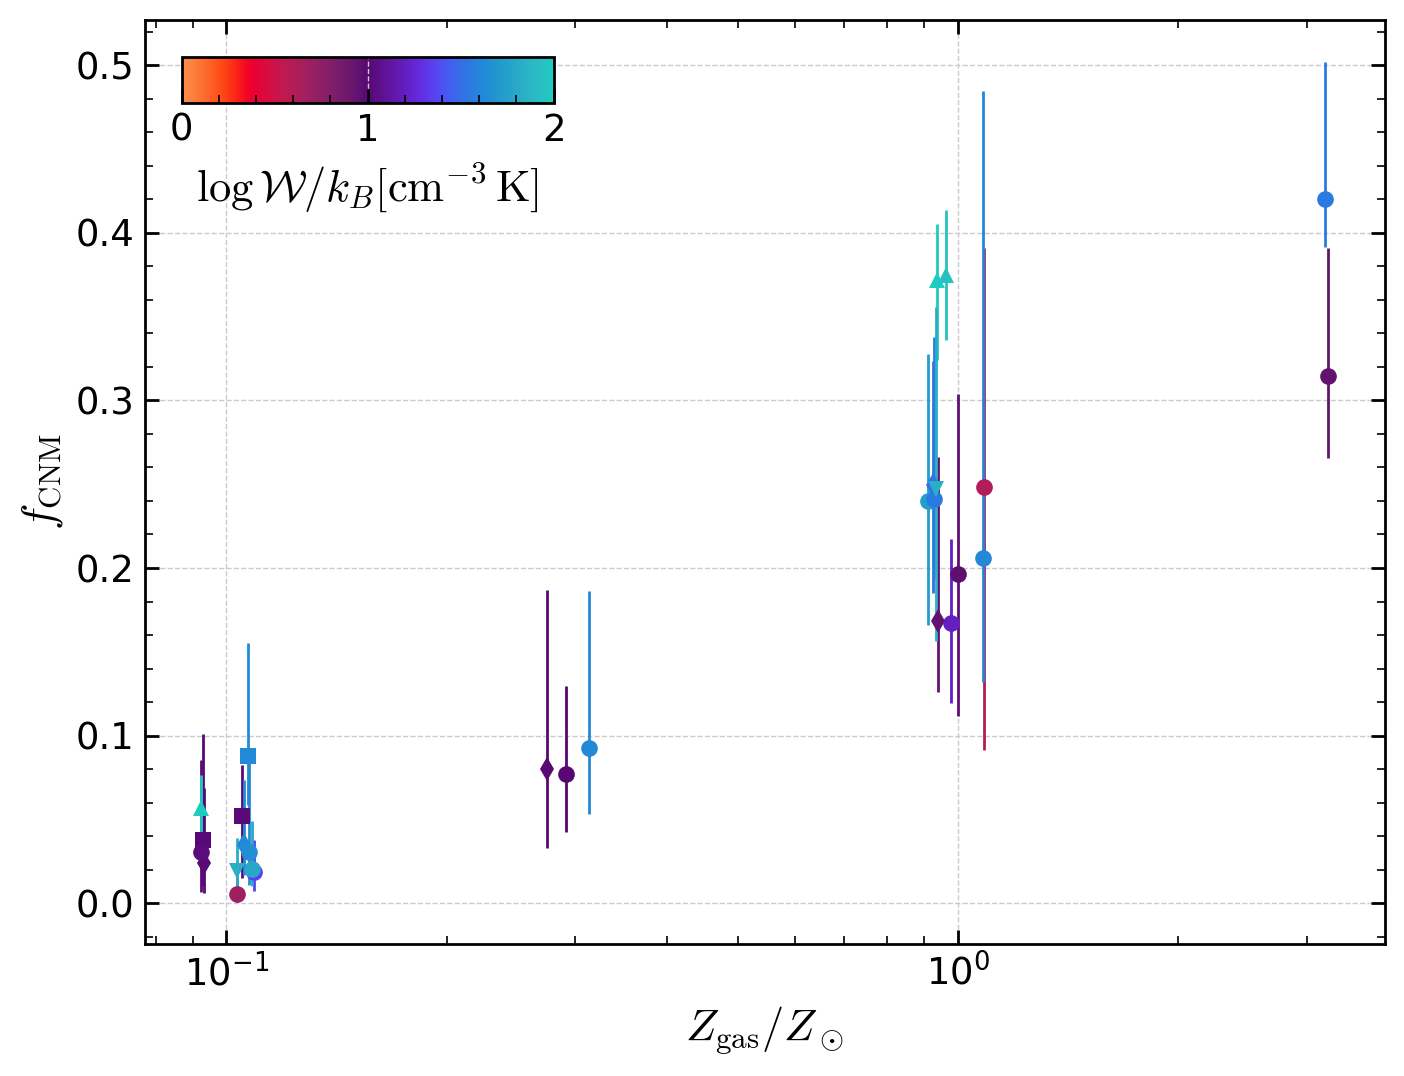

In [74]:
W = qdset.sel(variable="W",q="mean")
Sgas = qdset.sel(variable="Sigma_gas",q="mean")
for m in dsetall:
    print(m)
    zp_ph = dsetall[m]
    kwargs = dict(marker=get_symbol(m))
    color, sm =get_color(W.sel(name=m))
    color, sm =get_color(Sgas.sel(name=m),cmin=0,cmax=2)

    kwargs.update(dict(color=color))
    Z = get_Zgas_from_name(m)
    zmax = zp_ph["z"].max()
    # zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    plt.errorbar(Z*(0.9+0.2*np.random.rand()),qmid,[[qmid-ql],[qu-qmid]],
                 lw=1,mew=0,alpha=1,**kwargs)

    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

ax = plt.gca()
axins = inset_axes(ax, loc=2, borderpad=1, width="30%", height="5%")
cbar = plt.colorbar(
    sm, cax=axins, orientation="horizontal", label=r"$\log {\cal W}/k_B [{\rm cm^{-3}\,K}]$"
)

plt.sca(ax)
plt.xscale('log')
plt.xlabel(r"$Z_{\rm gas}/Z_\odot$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1.1,0)

# plt.yscale('log')
# plt.savefig("../figures/Z-phase-all.png")


R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8


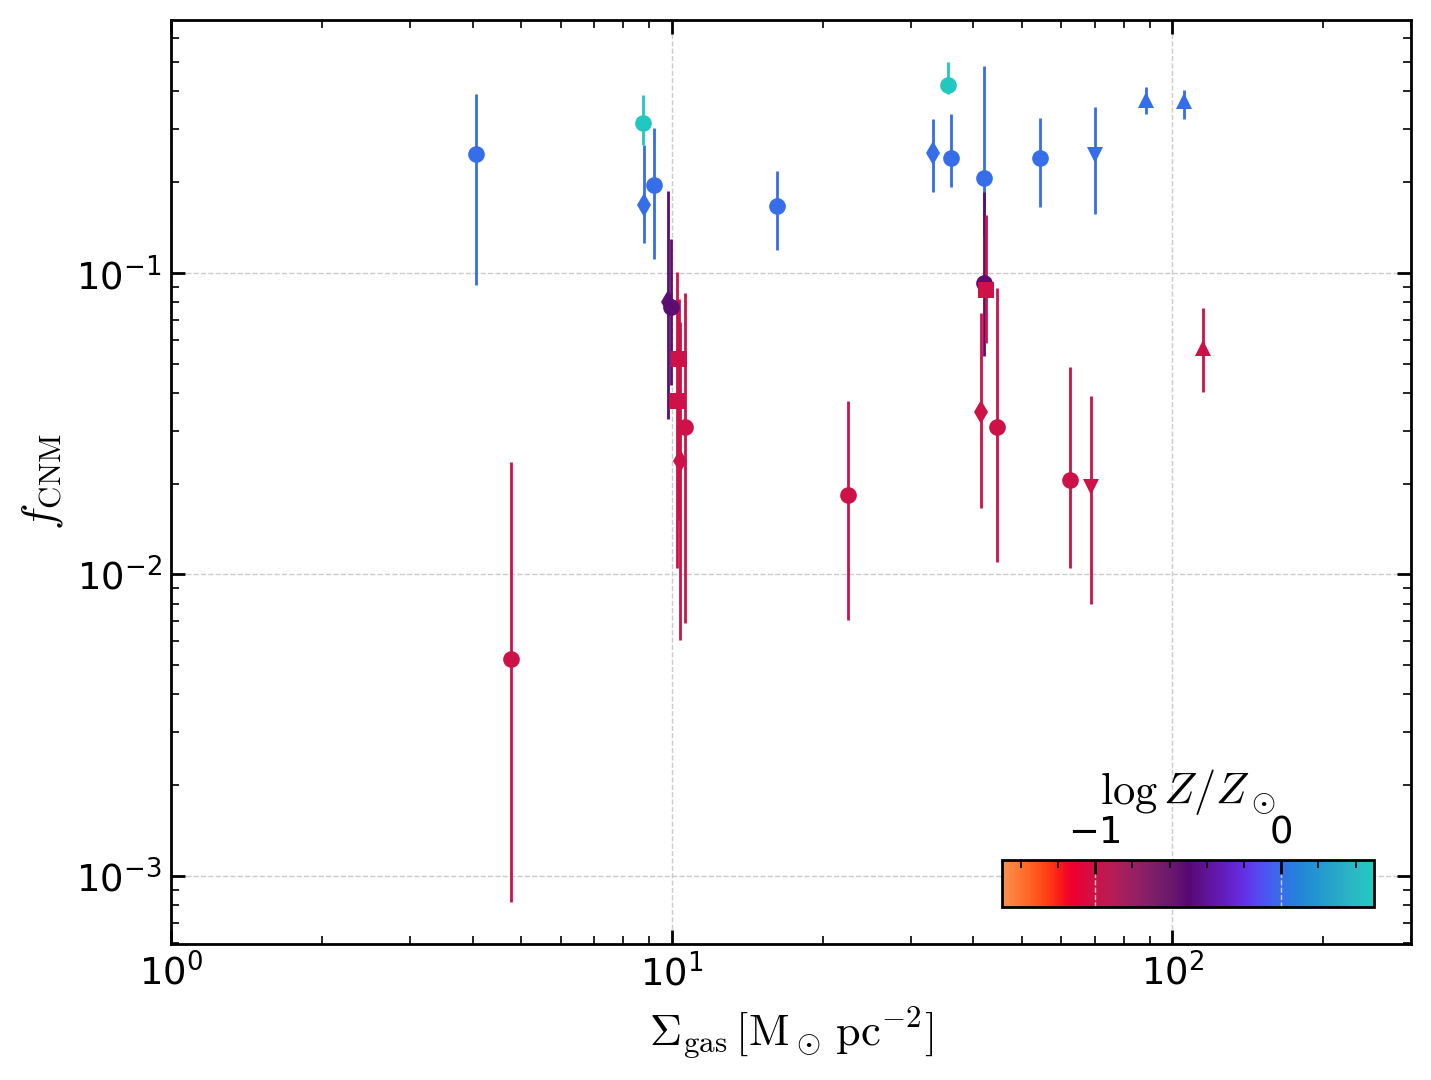

In [13]:
W = qdset.sel(variable="W",q="mean")
Sgas = qdset.sel(variable="Sigma_gas",q="mean")
for m in dsetall:
    print(m)
    zp_ph = dsetall[m]
    kwargs = dict(marker=get_symbol(m))
    Z = get_Zgas_from_name(m)
    # color, sm =get_color(W.sel(name=m))
    # color, sm =get_color(Sgas.sel(name=m),cmin=0,cmax=2)
    color, sm =get_color(Z,cmin=-1.5,cmax=0.5)
    kwargs.update(dict(color=color))
    Sg = Sgas.sel(name=m)
    zmax = zp_ph["z"].max()
    # zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Z*(0.9+0.2*np.random.rand()),qmid,[[qmid-ql],[qu-qmid]],
                #  lw=1,mew=0,alpha=1,**kwargs)
    plt.errorbar(Sg,qmid,[[qmid-ql],[qu-qmid]],
                 lw=1,mew=0,alpha=1,**kwargs)
    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

ax = plt.gca()
axins = inset_axes(ax, loc=4, borderpad=1, width="30%", height="5%")
cbar = plt.colorbar(
    sm, cax=axins, orientation="horizontal", label=r"$\log Z/Z_\odot$"
)
axins.xaxis.set_ticks_position("top")
axins.xaxis.set_label_position("top")
# plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

plt.sca(ax)
plt.xscale('log')
plt.xlabel(r"$\Sigma_{\rm gas}\,[{\rm M_\odot\,pc^{-2}}]$")
plt.ylabel(r"$f_{\rm CNM}$")
plt.xlim(1,3.e2)

plt.yscale('log')
plt.savefig("../figures/Sgas-Z-phase-all.png")


R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8


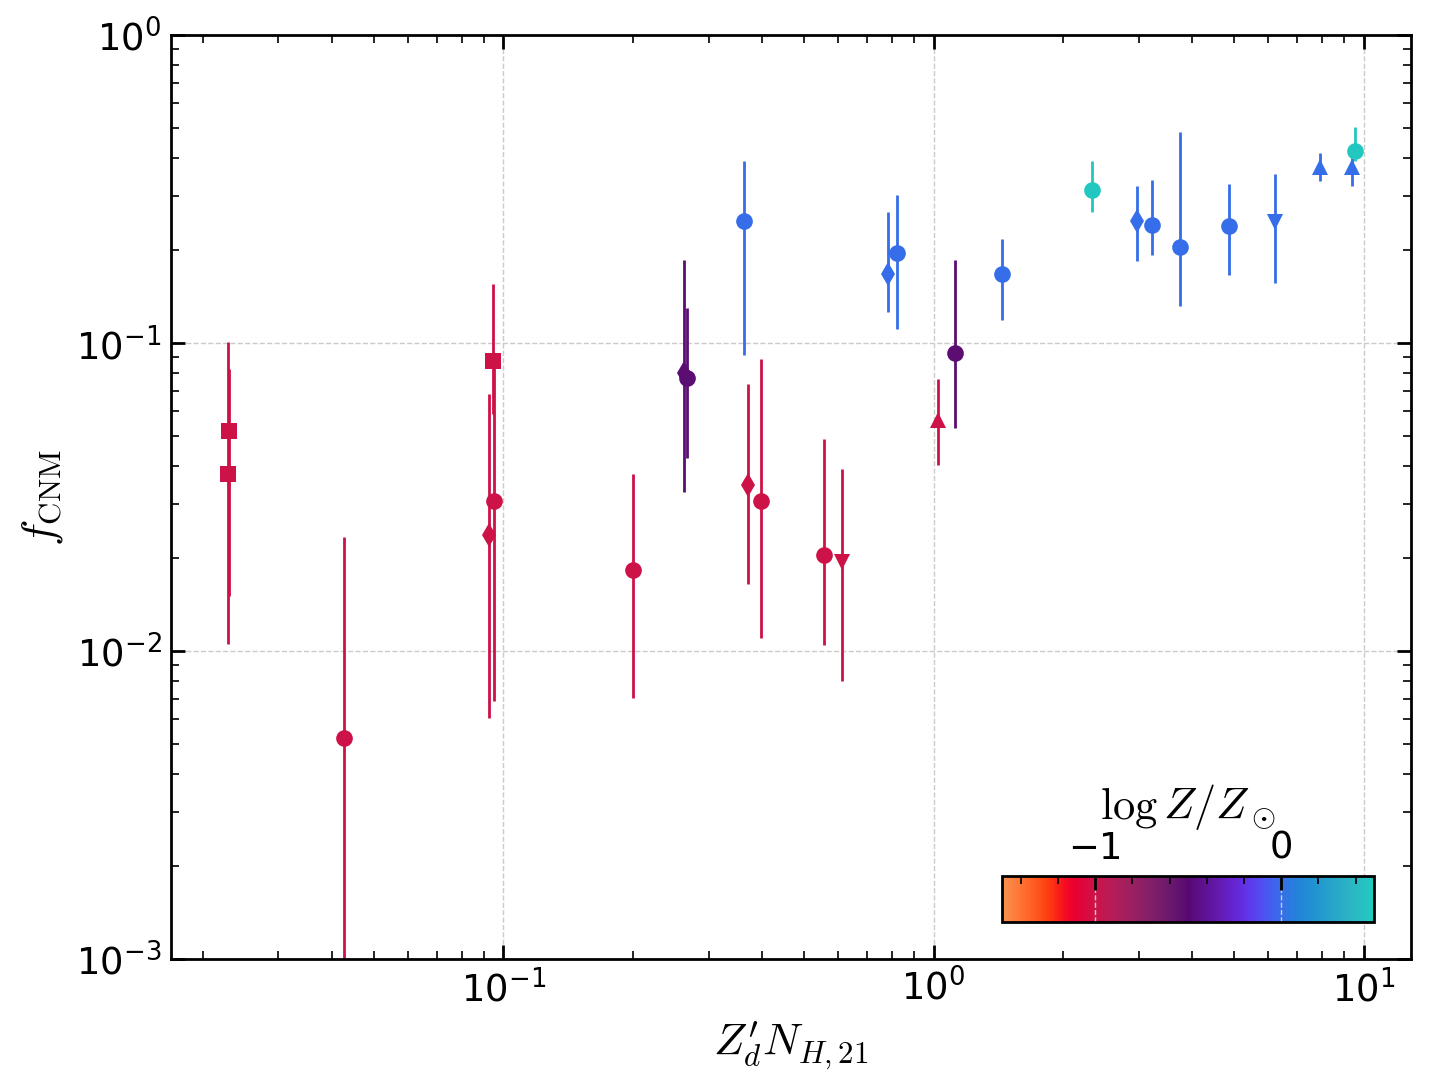

In [27]:
W = qdset.sel(variable="W",q="mean")
Sgas = qdset.sel(variable="Sigma_gas",q="mean")
for m in dsetall:
    print(m)
    zp_ph = dsetall[m]
    kwargs = dict(marker=get_symbol(m))
    Z = get_Zgas_from_name(m)
    Zd = get_Zdust_from_name(m)
    # color, sm =get_color(W.sel(name=m))
    # color, sm =get_color(Sgas.sel(name=m),cmin=0,cmax=2)
    color, sm =get_color(Z,cmin=-1.5,cmax=0.5)
    kwargs.update(dict(color=color))
    Sg = Sgas.sel(name=m)
    zmax = zp_ph["z"].max()
    # zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Z*(0.9+0.2*np.random.rand()),qmid,[[qmid-ql],[qu-qmid]],
                #  lw=1,mew=0,alpha=1,**kwargs)
    sig_PE = 1.e-21
    sig_LW = 2.e-21
    sigma = sig_PE
    kappa = sigma*au.cm**2/(1.4*ac.m_p)
    # tau = Zd*Sg*(kappa*ac.M_sun/ac.pc**2).cgs.value
    NH = Sg*(ac.M_sun/ac.pc**2/(1.4*ac.m_p)).cgs.value
    plt.errorbar(Zd*NH/1e21,qmid,[[qmid-ql],[qu-qmid]],
                 lw=1,mew=0,alpha=1,**kwargs)
    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

ax = plt.gca()
axins = inset_axes(ax, loc=4, borderpad=1, width="30%", height="5%")
cbar = plt.colorbar(
    sm, cax=axins, orientation="horizontal", label=r"$\log Z/Z_\odot$"
)
axins.xaxis.set_ticks_position("top")
axins.xaxis.set_label_position("top")
# plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

plt.sca(ax)
plt.xscale('log')
plt.xlabel(r"$Z_d' N_{H,21}$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1,3.e2)
plt.ylim(1.e-3,1)

plt.yscale('log')
plt.savefig("../figures/Sdust-phase-all.png")


In [62]:
mgroup=dict(S30=dict(name="R8_8pc_NCR_S30.full", color="C2",
            R8="R8_8pc_NCR.full",
            S05="LGR8_8pc_NCR_S05.full",
            LGR4="LGR4_4pc_NCR.full",
            S100="LGR4_4pc_NCR_S100.full",
            S150="LGR2_4pc_NCR_S150.full")

In [ ]:
for m in dsetall:
    for mg in mgroup:
        if mgroup[mg] in m:

    if not m.startswith("R8_8pc_NCR."):
        continue
    zp_ph = dsetall[m]
    # kwargs = dict(marker=get_symbol(m))
    if 'b10' in m:
        color="C3"
        offset=0.02
    else:
        color="C0"
        offset=-0.02
    Z = get_Zdust_from_name(m)
    marker="o"
    if Z == 0.025:
        offset = offset*2
        marker = "s"
    kwargs = dict(marker=marker,color=color,lw=1)
    # color, sm =get_color(W.sel(name=m))
    # color, sm =get_color(W.sel(name=m))
    # kwargs.update(dict(color=color))

    Z = get_Zgas_from_name(m)
    zmax = zp_ph["z"].max()
    zmax = 0
    fm = zp_ph["fmq"].sel(phase="CNM").sel(z=zmax,method='nearest')
    fm_H = zp_ph["fm"].sel(phase=["CNM","UNM","WNM"]).sum(dim="phase").sel(z=zmax,method='nearest')

    # ql, qmid, qu = (fm).sel(q=[0.16,0.5,0.84]).data
    # plt.plot(Zdust*(1+0.1*np.random.rand()),qmid,**kwargs)
    ql, qmid, qu = (fm/fm_H.data).sel(q=[0.16,0.5,0.84]).data
    plt.errorbar(Z*(1+offset),qmid,[[qmid-ql],[qu-qmid]],
                 mew=0,alpha=1,**kwargs)

    # fm = zp_ph["fmq"].sel(phase="CNM").sel(z=0,method="nearest")
    # ql, qmid, qu = fm.sel(q=[0.16,0.5,0.84]).data
    # plt.errorbar(Zdust+0.1*np.random.rand(),qmid,[[qmid-ql],[qu-qmid]],**kwargs)

# ax = plt.gca()
# axins = inset_axes(ax, loc=2, borderpad=1, width="30%", height="5%")
# cbar = plt.colorbar(
#     sm, cax=axins, orientation="horizontal", label=r"$\log {\cal W}/k_B [{\rm cm^{-3}\,K}]$"
# )
# plt.sca(ax)

plt.xscale('log')
plt.xlabel(r"$Z_{\rm gas}/Z_\odot$")
plt.ylabel(r"$f_{\rm CNM}$")
# plt.xlim(1.1,0)

# plt.yscale('log')

